# RATIO 2019 - Benchmarking Workshop

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
ln -s sentence_embedding/bert bert
```

In [67]:
import datetime
import logging
import os
import random
import time
import warnings

import csv
import gluonnlp as nlp
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import seaborn as sns

from bert import *
from mxboard import SummaryWriter
from mxnet import gluon
from mxnet.gluon.data import Dataset, SimpleDataset
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils
from tqdm import tqdm

In [68]:
%matplotlib inline

In [69]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [70]:
# set repeatable random state
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

In [71]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [72]:
# make tqdm jupyter friendly
from tqdm import tqdm_notebook as tqdm
# for .progress_apply() we have to hack it like this?
tqdm().pandas()

In [73]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [74]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'
new_within_test = 'data/same-side-classification/within-topic/within_test.csv'

### Load within-topics and cross-topics data

In [75]:
with Timer("read cross"):
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'),
                                    quotechar='"',
                                    quoting=csv.QUOTE_ALL,
                                    encoding='utf-8',
                                    escapechar='\\',
                                    doublequote=False,
                                    index_col='id')
    cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id')

with Timer("read within"):
    within_traindev_df = pd.read_csv(data_within_path.format('training'),
                                     quotechar='"',
                                     quoting=csv.QUOTE_ALL,
                                     encoding='utf-8',
                                     escapechar='\\',
                                     doublequote=False,
                                     index_col='id')
    # within_test_df = pd.read_csv(data_within_path.format('test'),
    #                              quotechar='"',
    #                              quoting=csv.QUOTE_ALL,
    #                              encoding='utf-8',
    #                              escapechar='\\',
    #                              doublequote=True,  # <-- change, "" as quote escape in text?
    #                              index_col='id')
    within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id')

with Timer("read new within"):
    new_within_test_df = pd.read_csv(new_within_test, index_col='id')

Time for [read cross]: 0:00:00.843436
Time for [read within]: 0:00:00.813130
Time for [read new within]: 0:00:00.353044


In [ ]:
! head -n 5 data/same-side-classification/within-topic/test.csv

In [ ]:
! head -n 5 data/same-side-classification/within-topic/within_test.csv

In [76]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.progress_apply(add_tag, axis=1)
with Timer("tag cross test"):
    cross_test_df = cross_test_df.progress_apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.progress_apply(add_tag, axis=1)
with Timer("tag within test"):
    within_test_df = within_test_df.progress_apply(add_tag, axis=1)
with Timer("tag new within test"):
    new_within_test_df = new_within_test_df.progress_apply(add_tag, axis=1)


Time for [tag cross traindev]: 0:00:32.932377



Time for [tag cross test]: 0:00:03.402511



Time for [tag within traindev]: 0:00:34.850193



Time for [tag within test]: 0:00:01.872121



Time for [tag new within test]: 0:00:16.794515


### Get an overview about each dataset

In [77]:
# requires nltk  wordtokenize
# from nltk.tokenize import sent_tokenize, word_tokenize
# model uses BERT Tokenizer ...

def get_overview(df, task='same-side', class_name='is_same_side'):
    # Total instance numbers
    total = len(df)
    print("Task: ", task)
    print('=' * 40, '\n')

    print('Total instances: ', total)
    print('\n')

    print('For each topic:')
    for tag, tag_df in df.groupby(['tag']):
        print(tag, ': ', len(tag_df), ' instances')
        if class_name in df.columns:
            for is_same_side, side_df in tag_df.groupby([class_name]):
                print('\t\t', is_same_side, ': ', len(side_df), ' instances')
    print('\n')

    if class_name in df.columns:
        print('For each class value:')
        for class_value, class_df in df.groupby([class_name]):
            print(class_value, ': ', len(class_df), ' instances')
        print('\n')

    print('Unique argument1:', len(df['argument1'].unique()))
    print('Unique argument2:', len(df['argument2'].unique()))
    arguments = df['argument1'].values
    arguments = np.concatenate([arguments, df['argument2'].values])

    print('Unique total arguments:', len(set(list(arguments))), '\n')
    
    return

    print('-' * 40, '\n')

    arguments_length_lst = [
        len(word_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_length_lst.extend(
        [len(word_tokenize(x)) for x in df['argument2'].values])
    print('Words:')
    print('\tshortest argument:', min(arguments_length_lst), ' words')
    print('\tlongest argument:', max(arguments_length_lst), ' words')
    print('\targument average length:', np.mean(arguments_length_lst),
          ' words')

    arguments_sent_length_lst = [
        len(sent_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_sent_length_lst.extend(
        [len(sent_tokenize(x)) for x in df['argument2'].values])
    print('Sentences:')
    print('\tshortest argument:', min(arguments_sent_length_lst), ' sentences')
    print('\tlongest argument:', max(arguments_sent_length_lst), ' sentences')
    print('\targument average length:', np.mean(arguments_sent_length_lst),
          ' sentences')

In [14]:
with Timer("overview cross"):
    get_overview(cross_traindev_df)

Task:  same-side

Total instances:  61048


For each topic:
abortion :  61048  instances
		 False :  29853  instances
		 True :  31195  instances


For each class value:
False :  29853  instances
True :  31195  instances


Unique argument1: 7828
Unique argument2: 7806
Unique total arguments: 9361 

Time for [overview cross]: 0:00:00.180387


In [15]:
with Timer("overview within"):
    get_overview(within_traindev_df)

Task:  same-side

Total instances:  63903


For each topic:
abortion :  40840  instances
		 False :  20006  instances
		 True :  20834  instances
gay marriage :  23063  instances
		 False :  9786  instances
		 True :  13277  instances


For each class value:
False :  29792  instances
True :  34111  instances


Unique argument1: 10508
Unique argument2: 10453
Unique total arguments: 13574 

Time for [overview within]: 0:00:00.224594


##### Count raw length

In [ ]:
def compute_arg_len(row):
    row['argument1_len'] = len(row['argument1'])
    row['argument2_len'] = len(row['argument2'])
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    row['argument12_len_diff_abs'] = np.abs(row['argument12_len_diff']
    return row


cross_traindev_df = cross_traindev_df.progress_apply(compute_arg_len, axis=1)
within_traindev_df = within_traindev_df.progress_apply(compute_arg_len, axis=1)
cross_test_df = cross_test_df.progress_apply(compute_arg_len, axis=1)
within_test_df = within_test_df.progress_apply(compute_arg_len, axis=1)

In [ ]:
cross_traindev_df.describe()

In [ ]:
within_traindev_df.describe()

In [ ]:
within_test_df.describe()

##### Tokenize and count tokens

In [16]:
ctx = mx.cpu()
_, vocabulary = nlp.model.get_model('bert_12_768_12',
                                    dataset_name='book_corpus_wiki_en_uncased',
                                    pretrained=True, ctx=ctx, use_pooler=True,
                                    use_decoder=False, use_classifier=False)
bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
tokenizer = bert_tokenizer

In [17]:
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('punct')


# tokenizer from BERT
def tokenize_arguments(row):
    # tokenize
    row['argument1_tokens'] = tokenizer(row['argument1'])
    row['argument2_tokens'] = tokenizer(row['argument2'])

    # count tokens
    row['argument1_len'] = len(row['argument1_tokens'])
    row['argument2_len'] = len(row['argument2_tokens'])
    # token number diff
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    row['argument12_len_diff_abs'] = np.abs(row['argument12_len_diff'])
    return row


cross_traindev_df = cross_traindev_df.progress_apply(tokenize_arguments, axis=1)
within_traindev_df = within_traindev_df.progress_apply(tokenize_arguments, axis=1)
cross_test_df = cross_test_df.progress_apply(tokenize_arguments, axis=1)
within_test_df = within_test_df.progress_apply(tokenize_arguments, axis=1)

In [18]:
cross_traindev_df.describe()

,argument1_len,argument2_len,argument12_len_diff,argument12_len_diff_abs
count,61048.000000,61048.000000,61048.000000,61048.000000
mean,264.863337,228.493382,36.369955,199.451563
std,438.187823,405.800206,388.217671,335.043546
min,3.000000,4.000000,-2837.000000,0.000000
25%,18.000000,17.000000,-55.000000,23.000000
50%,83.000000,72.000000,3.000000,71.000000
75%,258.000000,197.000000,88.000000,199.000000
max,2964.000000,2964.000000,2926.000000,2926.000000


In [19]:
within_traindev_df.describe()

,argument1_len,argument2_len,argument12_len_diff,argument12_len_diff_abs
count,63903.000000,63903.000000,63903.000000,63903.000000
mean,252.189647,219.179303,33.010344,190.980486
std,425.471105,393.925258,373.091463,322.199974
min,3.000000,4.000000,-2837.000000,0.000000
25%,15.000000,14.000000,-58.000000,23.000000
50%,85.000000,73.000000,2.000000,75.000000
75%,222.000000,179.000000,91.000000,178.000000
max,2825.000000,2964.000000,2724.000000,2837.000000


In [20]:
within_test_df.describe()

,argument1_len,argument2_len,argument12_len_diff,argument12_len_diff_abs
count,3552.000000,3552.000000,3552.000000,3552.000000
mean,504.283502,462.664414,41.619088,369.798705
std,548.058512,526.286693,562.168586,425.413402
min,4.000000,4.000000,-2733.000000,0.000000
25%,85.000000,78.750000,-153.250000,62.000000
50%,273.000000,238.500000,11.500000,206.000000
75%,767.000000,665.250000,247.250000,517.250000
max,2825.000000,2964.000000,2116.000000,2733.000000


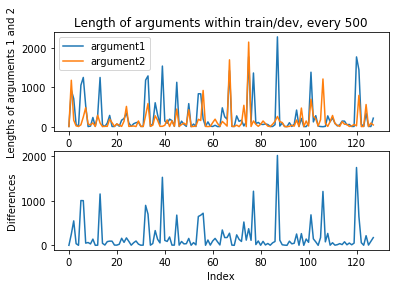

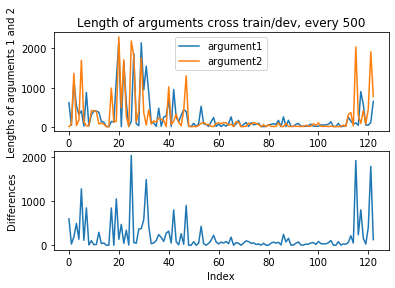

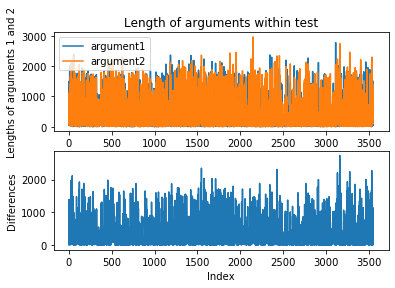

In [21]:
def plot_lengths(df, slicen=None, abs_diff=True, title=None):
    if df is None:
        print("no lengths to plot")
        return
    
    arg1_lens = df['argument1_len']
    arg2_lens = df['argument2_len']
    arg_diff_len = df['argument12_len_diff']
    
    if abs_diff:
        arg_diff_len = np.abs(arg_diff_len)
    
    if slicen is not None:
        arg1_lens = arg1_lens[slicen]
        arg2_lens = arg2_lens[slicen]
        arg_diff_len = arg_diff_len[slicen]

    x = np.arange(len(arg1_lens))  # arange/linspace

    plt.subplot(2, 1, 1)
    plt.plot(x, arg1_lens, label='argument1')  # Linie: '-', 'o-', '.-'
    plt.plot(x, arg2_lens, label='argument2')  # Linie: '-', 'o-', '.-'
    plt.legend()
    plt.title('Lengths of arguments' if not title else title)
    plt.ylabel('Lengths of arguments 1 and 2')

    plt.subplot(2, 1, 2)
    plt.plot(x, arg_diff_len)
    plt.xlabel('Index')
    plt.ylabel('Differences')

    plt.show()


plot_lengths(within_traindev_df, slice(None, None, 500), title='Length of arguments within train/dev, every 500')
plot_lengths(cross_traindev_df, slice(None, None, 500), title='Length of arguments cross train/dev, every 500')
plot_lengths(within_test_df, slice(None, None, 1), title='Length of arguments within test')

## Train model - Baseline

In [78]:
names_columns_X = ['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic']
names_columns_y = ['is_same_side']

### train dev set - 70% 30%

In [79]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[names_columns_X]
    y = df[names_columns_y]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### distinct train dev sets

In [80]:
import pickle


def load_distinct_data(name="within"):
    fn = "data/distinct_sets/{name}/{name}_{mode}_arg_pickle.pkl"
    fn_train = fn.format(mode="train", name=name)
    fn_dev = fn.format(mode="dev", name=name)

    with open(fn_train, "rb") as fp:
        train_df = pickle.load(fp)
    with open(fn_dev, "rb") as fp:
        dev_df = pickle.load(fp)

    X_train = train_df[names_columns_X]
    y_train = train_df[names_columns_y]
    X_dev = dev_df[names_columns_X]
    y_dev = dev_df[names_columns_y]
    
    return X_train, X_dev, y_train, y_dev

### within as a dev set for cross etc.

In [81]:
def split_within_by_topic(within_df):
    groups = within_df.groupby(['tag'])
    abortion_df = groups.get_group("abortion")
    gay_marriage_df = groups.get_group("gay marriage")
    
    X_abortion = abortion_df[names_columns_X]
    y_abortion = abortion_df[names_columns_y]
    X_gay_marriage = gay_marriage_df[names_columns_X]
    y_gay_marriage = gay_marriage_df[names_columns_y]
    
    return X_abortion, X_gay_marriage, y_abortion, y_gay_marriage

---

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [82]:
class MyBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(MyBERTDataset, self).__init__(self._convert())

    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                # allsamples.append([
                #     row['argument1'], row['argument2'],
                #     "1" if str(row['is_same_side']) == "True" else "0"
                # ])
                allsamples.append([
                    row['argument1'], row['argument2'],
                    1 if str(row['is_same_side']) == "True" else 0
                ])

        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])

        return allsamples

###### my own `BERTDatasetTransform` for extracting chunks from arguments or last part etc.

```python
transform = dataset.BERTDatasetTransform(bert_tokenizer, 512,
                                         labels=['0', '1'],
                                         label_dtype='int32',
                                         pad=True,
                                         pair=True)
```

http://localhost:9001/edit/bert/dataset.py @454
```python
# substitute with my own (e. g. last part, many parts etc.)
def __init__(...):
    self._bert_xform = BERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)
```
https://gluon-nlp.mxnet.io/master/_modules/gluonnlp/data/transforms.html#BERTSentenceTransform
```python
# substitute with my own (e. g. only last part (trim from start))
self._truncate_seq_pair(tokens_a, tokens_b, self._max_seq_length - 3)
```

https://mxnet.incubator.apache.org/_modules/mxnet/gluon/data/dataset.html#Dataset.transform

In [83]:
from gluonnlp.data import BERTSentenceTransform


class LastPartBERTSentenceTransform(BERTSentenceTransform):
    def __init__(self, tokenizer, max_seq_length, pad=True, pair=True):
        super(LastPartBERTSentenceTransform, self).__init__(tokenizer, max_seq_length, pad=pad, pair=pair)


    def _truncate_seq_pair(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length.
        Removes from end of token list."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop(0)
            else:
                tokens_b.pop(0)


class FirstAndLastPartBERTSentenceTransform(BERTSentenceTransform):
    def __init__(self, tokenizer, max_seq_length, pad=True, pair=True):
        super(FirstAndLastPartBERTSentenceTransform,
              self).__init__(tokenizer, max_seq_length, pad=pad, pair=pair)

    def __call__(self, line):
        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer(text_a)
        tokens_a_epi = tokens_a.copy()
        tokens_b = None
        tokens_b_epi = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)
            tokens_b_epi = tokens_b.copy()

        if tokens_b:
            self._truncate_seq_pair_prolog(tokens_a, tokens_b,
                                           self._max_seq_length - 3)
            self._truncate_seq_pair_epilog(tokens_a_epi, tokens_b_epi,
                                           self._max_seq_length - 3)
        else:
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]
            if len(tokens_a_epi) > self._max_seq_length - 2:
                tokens_a_epi = tokens_a_epi[0:(self._max_seq_length - 2)]

        vocab = self._tokenizer.vocab
        tokens, tokens_epi = [], []
        tokens.append(vocab.cls_token)
        tokens_epi.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens_epi.extend(tokens_a_epi)
        tokens.append(vocab.sep_token)
        tokens_epi.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)
        segment_ids_epi = [0] * len(tokens_epi)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens_epi.extend(tokens_b_epi)
            tokens.append(vocab.sep_token)
            tokens_epi.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))
            segment_ids_epi.extend([1] * (len(tokens) - len(segment_ids_epi)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)
        input_ids_epi = self._tokenizer.convert_tokens_to_ids(tokens_epi)
        valid_length = len(input_ids)
        valid_length_epi = len(input_ids_epi)

        if self._pad:
            padding_length = self._max_seq_length - valid_length
            padding_length_epi = self._max_seq_length - valid_length_epi
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            input_ids_epi.extend([vocab[vocab.padding_token]] *
                                 padding_length_epi)
            segment_ids.extend([0] * padding_length)
            segment_ids_epi.extend([0] * padding_length_epi)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32'), np.array(input_ids_epi, dtype='int32'),\
            np.array(valid_length_epi, dtype='int32'), np.array(segment_ids_epi, dtype='int32')

    def _truncate_seq_pair_prolog(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
            else:
                tokens_b.pop()

    def _truncate_seq_pair_epilog(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length.
        Removes from end of token list."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop(0)
            else:
                tokens_b.pop(0)

In [84]:
class LastPartBERTDatasetTransform(dataset.BERTDatasetTransform):
    def __init__(self, tokenizer, max_seq_length, labels=None, pad=True, pair=True, label_dtype='float32'):
        super(LastPartBERTDatasetTransform, self).__init__(tokenizer, max_seq_length, labels=labels, pad=pad, pair=pair, label_dtype=label_dtype)
        self._bert_xform = LastPartBERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)


class FirstAndLastPartBERTDatasetTransform(dataset.BERTDatasetTransform):
    def __init__(self,
                 tokenizer,
                 max_seq_length,
                 labels=None,
                 pad=True,
                 pair=True,
                 label_dtype='float32'):
        super(FirstAndLastPartBERTDatasetTransform,
              self).__init__(tokenizer,
                             max_seq_length,
                             labels=labels,
                             pad=pad,
                             pair=pair,
                             label_dtype=label_dtype)
        self._bert_xform = FirstAndLastPartBERTSentenceTransform(
            tokenizer, max_seq_length, pad=pad, pair=pair)

    def __call__(self, line):
        input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi = self._bert_xform(
            line[:-1])

        label = line[-1]

        # if label is None than we are predicting unknown data
        if label is None:
            # early abort
            return input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi
            
        if self.labels:  # for classification task
            label = self._label_map[label]
        label = np.array([label], dtype=self.label_dtype)

        return input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi, label

In [85]:
from mxnet.gluon import Block
from mxnet.gluon import nn


class BERTProEpiClassifier(Block):
    """Model for sentence (pair) classification task with BERT.

    The model feeds token ids and token type ids into BERT to get the
    pooled BERT sequence representation, then apply a Dense layer for
    classification. Does this also for an adversarial classifier.

    Parameters
    ----------
    bert: BERTModel
        Bidirectional encoder with transformer.
    num_classes : int, default is 2
        The number of target classes.
    dropout : float or None, default 0.0.
        Dropout probability for the bert output.
    prefix : str or None
        See document of `mx.gluon.Block`.
    params : ParameterDict or None
        See document of `mx.gluon.Block`.
    """

    def __init__(self,
                 bert,
                 num_classes=2,
                 dropout=0.0,
                 prefix=None,
                 params=None):
        super(BERTProEpiClassifier, self).__init__(prefix=prefix, params=params)
        self.bert = bert
        with self.name_scope():
            self.classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.classifier.add(nn.Dropout(rate=dropout))
            self.classifier.add(nn.Dense(units=num_classes))

    def forward(self,
                inputs,
                token_types,
                valid_length=None,
                inputs_epi=None,
                token_types_epi=None,
                valid_length_epi=None):  # pylint: disable=arguments-differ
        """Generate the unnormalized scores for the given the input sequences.
        From both classifiers (classifier + adversarial_classifier).

        Parameters
        ----------
        inputs : NDArray, shape (batch_size, seq_length)
            Input words for the sequences.
        token_types : NDArray, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one.
        valid_length : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.
        inputs_epi : NDArray or None, shape (batch_size, seq_length)
            Input words for the sequences. If None then same as inputs.
        token_types_epi : NDArray or None, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one. If None then same as token_types.
        valid_length_epi : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.

        Returns
        -------
        outputs : NDArray
            Shape (batch_size, num_classes), outputs of classifier.
        """
        # if inputs_epi is None and token_types_epi is None:
        #     inputs_epi = inputs
        #     token_types_epi = token_types
        #     valid_length_epi = valid_length

        _, pooler_out = self.bert(inputs, token_types, valid_length)
        _, pooler_out_epi = self.bert(inputs_epi, token_types_epi, valid_length_epi)
        pooler_concat = mx.nd.concat(pooler_out, pooler_out_epi, dim=1)
        return self.classifier(pooler_concat)

In [86]:
def setup_bert():
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(1)
    # ctx = [mx.gpu(i) for i in range(2)]
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()

    bert_base, vocabulary = nlp.model.get_model(
        'bert_12_768_12',
        dataset_name='book_corpus_wiki_en_uncased',
        pretrained=True,
        ctx=ctx,
        use_pooler=True,
        use_decoder=False,
        use_classifier=False)
    # print(bert_base)

    # model = BERTProEpiClassifier(bert_base, num_classes=2, dropout=0.1)
    # model = BERTProEpiClassifier(bert_base, num_classes=1, dropout=0.1)
    model = bert.BERTClassifier(bert_base, num_classes=1, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # softmax cross entropy loss for classification
    #loss_function = gluon.loss.SoftmaxCELoss()
    # sigmoid binary cross entropy loss for classification
    loss_function = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
    loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()

    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    # max_len = 128  # + batch_size: 32
    # 384 - 12
    max_len = 512  # + batch_size: 6 ?
    # the labels for the two classes
    #all_labels = ["0", "1"]
    all_labels = [0, 1]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    # transform = FirstAndLastPartBERTDatasetTransform(bert_tokenizer,
    #                                                  max_len,
    #                                                  labels=all_labels,
    #                                                  label_dtype='int32',
    #                                                  pad=True,
    #                                                  pair=True)
    transform = LastPartBERTDatasetTransform(bert_tokenizer, max_len,
                                             labels=all_labels,
                                             label_dtype='int32',
                                             pad=True,
                                             pair=True)

    return model, vocabulary, ctx, bert_tokenizer, transform, loss_function, metric, all_labels

In [87]:
def transform_dataset(X, y, transform):
    data_train_raw = MyBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def predict_out_to_ys(all_predictions, all_labels):
    y_true, y_pred = list(), list()

    for _, y_true_many, y_pred_many in all_predictions:
        y_true_many = y_true_many.T[0].asnumpy()
        # https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss
        # pred: the prediction tensor, where the batch_axis dimension ranges over batch size and axis dimension ranges over the number of classes.
        #y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()
        y_pred_many = y_pred_many.asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        # TODO: convert label_id to label?
        # y_pred.extend(all_labels[c] for c in list(y_pred_many))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return y_true, y_pred

Multi-GPU?
- https://gluon.mxnet.io/chapter07_distributed-learning/multiple-gpus-gluon.html

In [88]:
def train(model,
          data_train,
          ctx,
          metric,
          loss_function,
          batch_size=32,
          lr=5e-6,
          num_epochs=3,
          sw=None,
          checkpoint_dir="data",
          use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [
            p for p in model.collect_params().values() if p.grad_req != 'null'
        ]

    log_interval = 500
    global_step = 0
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(
                    epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(
                        checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                global_step = epoch_id * len(bert_dataloader)
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               label) in enumerate(tqdm(bert_dataloader)):
                    global_step += 1
                    with mx.autograd.record():
                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        label = label.as_in_context(ctx)

                        # forward computation
                        out = model(token_ids, segment_ids,
                                    valid_length.astype('float32'))
                        label = label.astype('float32')
                        ls = loss_function(out, label).mean()

                    # backward computation
                    ls.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    step_loss += ls.asscalar()
                    out = out.sigmoid().round().astype('int32')
                    label = label.astype('int32')
                    metric.update([label], [out])
                    stats.append((metric.get()[1], ls.asscalar()))

                    if sw:
                        sw.add_scalar(tag='T-ls', value=ls.asscalar(), global_step=global_step)
                        sw.add_scalar(tag='T-acc', value=metric.get()[1], global_step=global_step)

                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(
                                epoch_id, batch_id + 1, len(bert_dataloader),
                                step_loss / log_interval,
                                trainer.learning_rate,
                                metric.get()[1],
                                datetime.timedelta(seconds=(time.time() -
                                                            t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)

    return stats


def train_proepi(model,
          data_train,
          ctx,
          metric,
          loss_function,
          batch_size=32,
          lr=5e-6,
          num_epochs=3,
          sw=None,
          checkpoint_dir="data",
          use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [
            p for p in model.collect_params().values() if p.grad_req != 'null'
        ]

    log_interval = 500
    global_step = 0
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(
                    epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(
                        checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                global_step = epoch_id * len(bert_dataloader)
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               token_ids_epi, valid_length_epi,
                               segment_ids_epi,
                               label) in enumerate(tqdm(bert_dataloader)):
                    global_step += 1
                    with mx.autograd.record():
                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        token_ids_epi = token_ids_epi.as_in_context(ctx)
                        valid_length_epi = valid_length_epi.as_in_context(ctx)
                        segment_ids_epi = segment_ids_epi.as_in_context(ctx)
                        label = label.as_in_context(ctx)

                        # forward computation
                        out = model(token_ids, segment_ids,
                                    valid_length.astype('float32'),
                                    token_ids_epi, segment_ids_epi,
                                    valid_length_epi.astype('float32'))
                        label = label.astype('float32')
                        ls = loss_function(out, label).mean()

                    # backward computation
                    ls.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    step_loss += ls.asscalar()
                    out = out.sigmoid().round().astype('int32')
                    label = label.astype('int32')
                    metric.update([label], [out])
                    stats.append((metric.get()[1], ls.asscalar()))

                    if sw:
                        sw.add_scalar(tag='T-ls', value=ls.asscalar(), global_step=global_step)
                        sw.add_scalar(tag='T-acc', value=metric.get()[1], global_step=global_step)

                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(
                                epoch_id, batch_id + 1, len(bert_dataloader),
                                step_loss / log_interval,
                                trainer.learning_rate,
                                metric.get()[1],
                                datetime.timedelta(seconds=(time.time() -
                                                            t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)

    return stats

In [89]:
def train_multi(model,
                data_train,
                ctx,
                metric,
                loss_function,
                batch_size=32,
                lr=5e-6,
                num_epochs=3,
                checkpoint_dir="data",
                use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(),
                                'adam', {
                                    'learning_rate': lr,
                                    'epsilon': 1e-9
                                },
                                update_on_kvstore=False)

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [
            p for p in model.collect_params().values() if p.grad_req != 'null'
        ]

    log_interval = 500
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(
                    epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(
                        checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               label) in enumerate(bert_dataloader):
                    with mx.autograd.record():
                        # load data to GPU
                        token_ids = gluon.utils.split_and_load(
                            token_ids, ctx, even_split=False)
                        valid_length = gluon.utils.split_and_load(
                            valid_length, ctx, even_split=False)
                        segment_ids = gluon.utils.split_and_load(
                            segment_ids, ctx, even_split=False)
                        label = gluon.utils.split_and_load(label,
                                                           ctx,
                                                           even_split=False)

                        # forward computation
                        out = [
                            model(t1, s1, v1.astype('float32'), t2, s2,
                                  v2.astype('float32'))
                            for t1, s1, v1, t2, s2, v2 in zip(
                                token_ids, segment_ids, valid_length)
                        ]
                        ls = [
                            loss_function(o, l.astype('float32')).mean()
                            for o, l in zip(out, label)
                        ]

                    # backward computation
                    for l in ls:
                        l.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    for l in ls:
                        step_loss += l.asscalar()
                    for o, l in zip(out, label):
                        metric.update([l.astype('int32')],
                                      [o.sigmoid().round().astype('int32')])
                    stats.append((metric.get()[1], [l.asscalar() for l in ls]))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(
                                epoch_id, batch_id + 1, len(bert_dataloader),
                                step_loss / log_interval,
                                trainer.learning_rate,
                                metric.get()[1],
                                datetime.timedelta(seconds=(time.time() -
                                                            t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)

    return stats


def train_multi_proepi(model,
                data_train,
                ctx,
                metric,
                loss_function,
                batch_size=32,
                lr=5e-6,
                num_epochs=3,
                checkpoint_dir="data",
                use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(),
                                'adam', {
                                    'learning_rate': lr,
                                    'epsilon': 1e-9
                                },
                                update_on_kvstore=False)

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [
            p for p in model.collect_params().values() if p.grad_req != 'null'
        ]

    log_interval = 500
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(
                    epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(
                        checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               token_ids_epi, valid_length_epi,
                               segment_ids_epi,
                               label) in enumerate(bert_dataloader):
                    with mx.autograd.record():
                        # load data to GPU
                        token_ids = gluon.utils.split_and_load(
                            token_ids, ctx, even_split=False)
                        valid_length = gluon.utils.split_and_load(
                            valid_length, ctx, even_split=False)
                        segment_ids = gluon.utils.split_and_load(
                            segment_ids, ctx, even_split=False)
                        token_ids_epi = gluon.utils.split_and_load(
                            token_ids_epi, ctx, even_split=False)
                        valid_length_epi = gluon.utils.split_and_load(
                            valid_length_epi, ctx, even_split=False)
                        segment_ids_epi = gluon.utils.split_and_load(
                            segment_ids_epi, ctx, even_split=False)
                        label = gluon.utils.split_and_load(label,
                                                           ctx,
                                                           even_split=False)

                        # forward computation
                        out = [
                            model(t1, s1, v1.astype('float32'), t2, s2,
                                  v2.astype('float32'))
                            for t1, s1, v1, t2, s2, v2 in zip(
                                token_ids, segment_ids, valid_length,
                                token_ids_epi, segment_ids_epi,
                                valid_length_epi)
                        ]
                        ls = [
                            loss_function(o, l.astype('float32')).mean()
                            for o, l in zip(out, label)
                        ]

                    # backward computation
                    for l in ls:
                        l.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    for l in ls:
                        step_loss += l.asscalar()
                    for o, l in zip(out, label):
                        metric.update([l.astype('int32')],
                                      [o.sigmoid().round().astype('int32')])
                    stats.append((metric.get()[1], [l.asscalar() for l in ls]))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(
                                epoch_id, batch_id + 1, len(bert_dataloader),
                                step_loss / log_interval,
                                trainer.learning_rate,
                                metric.get()[1],
                                datetime.timedelta(seconds=(time.time() -
                                                            t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)

    return stats

In [90]:
def predict(model, data_predict, ctx, metric, loss_function, batch_size=32, sw=None):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict,
                                               batch_size=batch_size)

    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        for batch_id, (token_ids, valid_length, segment_ids,
                       label) in enumerate(tqdm(bert_dataloader)):
            global_step = batch_id
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'))
            label = label.astype('float32')
            ls = loss_function(out, label).mean()

            out = out.sigmoid().round().astype('int32')
            label = label.astype('int32')
            metric.update([label], [out])
            cum_loss += ls.asscalar()  # .sum() ?

            if sw:
                sw.add_scalar(tag='P-ls', value=ls.asscalar(), global_step=global_step)
                sw.add_scalar(tag='P-acc', value=metric.get()[1], global_step=global_step)

            all_predictions.append((batch_id, label, out))

    return all_predictions, cum_loss


def predict_proepi(model, data_predict, ctx, metric, loss_function, batch_size=32, sw=None):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict,
                                               batch_size=batch_size)

    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        for batch_id, (token_ids, valid_length, segment_ids, token_ids_epi,
                       valid_length_epi, segment_ids_epi,
                       label) in enumerate(tqdm(bert_dataloader)):
            global_step = batch_id
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            token_ids_epi = token_ids_epi.as_in_context(ctx)
            valid_length_epi = valid_length_epi.as_in_context(ctx)
            segment_ids_epi = segment_ids_epi.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'),
                        token_ids_epi, segment_ids_epi,
                        valid_length_epi.astype('float32'))
            label = label.astype('float32')
            ls = loss_function(out, label).mean()

            out = out.sigmoid().round().astype('int32')
            label = label.astype('int32')
            metric.update([label], [out])
            cum_loss += ls.asscalar()  # .sum() ?

            if sw:
                sw.add_scalar(tag='P-ls', value=ls.asscalar(), global_step=global_step)
                sw.add_scalar(tag='P-acc', value=metric.get()[1], global_step=global_step)

            all_predictions.append((batch_id, label, out))

    return all_predictions, cum_loss

In [91]:
def predict_unknown(model, data_predict, ctx, label_map=None, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict,
                                               batch_size=batch_size)

    predictions = list()

    with Timer("prediction"):
        for batch_id, (token_ids, valid_length, segment_ids) in enumerate(tqdm(bert_dataloader)):
            global_step = batch_id
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'))

            # to binary: 0/1
            out = out.sigmoid().round().astype('int32')
            # to numpy (not mxnet)
            out = out.asnumpy()
            # get mapping type
            if label_map:
                out = [label_map[c] for c in list(out)]

            predictions.extend(out)

    # list to numpy array
    predictions = np.array(predictions)

    return predictions


def predict_unknown_proepi(model, data_predict, ctx, label_map=None, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict,
                                               batch_size=batch_size)

    predictions = list()

    with Timer("prediction"):
        for batch_id, (token_ids, valid_length, segment_ids, token_ids_epi,
                       valid_length_epi,
                       segment_ids_epi) in enumerate(tqdm(bert_dataloader)):
            global_step = batch_id
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            token_ids_epi = token_ids_epi.as_in_context(ctx)
            valid_length_epi = valid_length_epi.as_in_context(ctx)
            segment_ids_epi = segment_ids_epi.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'),
                        token_ids_epi, segment_ids_epi,
                        valid_length_epi.astype('float32'))

            # to binary: 0/1
            out = out.sigmoid().round().astype('int32')
            # to numpy (not mxnet)
            out = out.asnumpy()
            # get mapping type
            if label_map:
                out = [label_map[c] for c in list(out)]

            predictions.extend(out)

    # list to numpy array
    predictions = np.array(predictions)

    return predictions

In [92]:
def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s' % vocabulary)
    print('[PAD] token id = %s' % (vocabulary['[PAD]']))
    print('[CLS] token id = %s' % (vocabulary['[CLS]']))
    print('[SEP] token id = %s' % (vocabulary['[SEP]']))

    print('token ids = \n%s' % data_train[sample_id][0])
    print('valid length = \n%s' % data_train[sample_id][1])
    print('segment ids = \n%s' % data_train[sample_id][2])
    print('label = \n%s' % data_train[sample_id][3])


def print_infos_proepi(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s' % vocabulary)
    print('[PAD] token id = %s' % (vocabulary['[PAD]']))
    print('[CLS] token id = %s' % (vocabulary['[CLS]']))
    print('[SEP] token id = %s' % (vocabulary['[SEP]']))

    print('token ids = \n%s' % data_train[sample_id][0])
    print('valid length = \n%s' % data_train[sample_id][1])
    print('segment ids = \n%s' % data_train[sample_id][2])
    print('epi token ids = \n%s' % data_train[sample_id][3])
    print('epi valid length = \n%s' % data_train[sample_id][4])
    print('epi segment ids = \n%s' % data_train[sample_id][5])
    print('label = \n%s' % data_train[sample_id][6])


def plot_train_stats(stats):
    if not stats:
        print("no stats to plot")
        return

    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots = zip(*stats)
    # if isinstance(loss_dots, tuple):
    #     loss_dots, loss_dots2 = zip(*loss_dots)

    plt.subplot(2, 1, 1)
    plt.plot(x, acc_dots)  # Linie: '-', 'o-', '.-'
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_dots)
    plt.xlabel('Batches')
    plt.ylabel('Loss')

    plt.show()

### Evaluate

In [93]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(y_test)))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test, y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Within topic - Training and evaluating model 

In [ ]:
#within_traindev_df = within_traindev_df[:1000]

In [ ]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df, ratio=0.1)
    # X_train, X_dev, y_train, y_dev = load_distinct_data("within")

    X_abortion, X_gay_marriage, y_abortion, y_gay_marriage = split_within_by_topic(within_traindev_df)

In [ ]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
# print(model)

In [ ]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

In [ ]:
run_name = "within_traindev_epi512_BCE_0.1"

In [ ]:
! mkdir data/within_traindev_epi512_BCE_0.1

In [ ]:
with Timer("4 - train model"), SummaryWriter(logdir="data/" + run_name, flush_secs=600) as sw:
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=2, lr=5e-6, num_epochs=5, sw=sw, checkpoint_dir="data/" + run_name)
    model.save_parameters("data/" + run_name + "/bert.model.params")

    plot_train_stats(stats)

In [ ]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("6 - evaluate"), SummaryWriter(logdir="data/" + run_name, flush_secs=60) as sw:
    # model.load_parameters("data/" + run_name + "/bert.model.params", ctx=ctx)
    # bert.model.checkpoint4.params
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2, sw=sw)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier - BCE epilog 0.1 split", heatmap=False)

### Train and evaluate each epoch

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        # stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=2, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        # stats = train_multi(model, data_train, ctx, metric, loss_function, batch_size=4, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        # all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier - last part", heatmap=False)

    model.save_parameters("data/bert.model.params")

### Cross topic - Training and evaluating model 

In [28]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_traindev_df, ratio=0.1)
    # X_train, X_dev, y_train, y_dev = load_distinct_data("cross")

    X_abortion, X_gay_marriage, y_abortion, y_gay_marriage = split_within_by_topic(within_traindev_df)
    
    # cross:  abortion
    # within: abortion + gay marriage

Time for [1 - test/train split]: 0:00:00.033282


In [29]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

Time for [2 - setup BERT model]: 0:00:02.414871


In [30]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

i thank pro for pushing me to find evidence to prove my case due to pro providing evidence as well. it is only fair to do the same. even without all of this information, a fetus still responds to stimuli at 8 weeks of development even though pain is not known to register at this stage. responding is the different to actually feeling it. at 8 weeks i clearly stated the fetus would not even have the neurons connected to the brain in order to actually feel tha pain. if the baby does feel pain at 8 weeks then how would it know without the neurons connected to the brain? pro left that unaswered. why is it that 'pain' quantifies human life? it wasn't pain instead it was the defintion i gave to be a human being. the case was given in order to find out what is a moral time to abort a fetus if the woman cared about the fetus feelings pain and acutally knowing it is. knowing it is important because if a person is braindead they are actually dead. brain does so much for a human and if they do not

In [31]:
run_name = "cross_traindev_epi512_BCE_0.1"

In [32]:
! mkdir data/cross_traindev_epi512_BCE_0.1

mkdir: cannot create directory ‘data/cross_traindev_epi512_BCE_0.1’: File exists


In [ ]:
with Timer("4 - train model"), SummaryWriter(logdir="data/" + run_name, flush_secs=600) as sw:
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=6, lr=5e-6, num_epochs=5, sw=sw, checkpoint_dir="data/" + run_name)
    model.save_parameters("data/" + run_name + "/bert.model.params")

    plot_train_stats(stats)


Time for [setup training]: 0:04:25.959248


2019-11-26 14:14:37,746 : INFO : successfully opened events file: data/cross_traindev_epi512_BCE_0.1/events.out.tfevents.1574774077.cuda
2019-11-26 14:14:37,791 : INFO : wrote 1 event to disk
2019-11-26 14:14:37,792 : INFO : wrote 1 event to disk


[Epoch 0 Batch 500/9162] loss=0.6764, lr=0.0000050, acc=0.579 - time 0:07:29.582800


2019-11-26 14:24:38,571 : INFO : wrote 1342 events to disk


[Epoch 0 Batch 1000/9162] loss=0.6220, lr=0.0000050, acc=0.618 - time 0:07:23.269249


2019-11-26 14:34:38,728 : INFO : wrote 1344 events to disk


[Epoch 0 Batch 1500/9162] loss=0.5301, lr=0.0000050, acc=0.656 - time 0:07:29.849516
[Epoch 0 Batch 2000/9162] loss=0.4382, lr=0.0000050, acc=0.688 - time 0:07:30.711848


2019-11-26 14:44:39,092 : INFO : wrote 1332 events to disk


[Epoch 0 Batch 2500/9162] loss=0.3639, lr=0.0000050, acc=0.716 - time 0:07:27.666973


2019-11-26 14:54:39,432 : INFO : wrote 1340 events to disk


[Epoch 0 Batch 3000/9162] loss=0.3656, lr=0.0000050, acc=0.734 - time 0:07:29.073182


2019-11-26 15:04:39,663 : INFO : wrote 1336 events to disk


[Epoch 0 Batch 3500/9162] loss=0.3715, lr=0.0000050, acc=0.746 - time 0:07:30.132334
[Epoch 0 Batch 4000/9162] loss=0.3709, lr=0.0000050, acc=0.755 - time 0:07:29.690588


2019-11-26 15:14:40,356 : INFO : wrote 1334 events to disk


[Epoch 0 Batch 4500/9162] loss=0.3434, lr=0.0000050, acc=0.765 - time 0:07:30.169179


2019-11-26 15:24:41,211 : INFO : wrote 1336 events to disk


[Epoch 0 Batch 5000/9162] loss=0.3111, lr=0.0000050, acc=0.774 - time 0:07:28.427568


2019-11-26 15:34:41,398 : INFO : wrote 1336 events to disk


[Epoch 0 Batch 5500/9162] loss=0.3028, lr=0.0000050, acc=0.781 - time 0:07:30.406369
[Epoch 0 Batch 6000/9162] loss=0.3134, lr=0.0000050, acc=0.786 - time 0:07:29.811242


2019-11-26 15:44:41,467 : INFO : wrote 1334 events to disk


[Epoch 0 Batch 6500/9162] loss=0.3170, lr=0.0000050, acc=0.790 - time 0:07:31.537196


2019-11-26 15:54:41,575 : INFO : wrote 1330 events to disk


[Epoch 0 Batch 7000/9162] loss=0.2870, lr=0.0000050, acc=0.794 - time 0:07:29.050002


2019-11-26 16:04:41,894 : INFO : wrote 1336 events to disk


[Epoch 0 Batch 7500/9162] loss=0.3149, lr=0.0000050, acc=0.798 - time 0:07:30.796250
[Epoch 0 Batch 8000/9162] loss=0.2897, lr=0.0000050, acc=0.801 - time 0:07:30.603429


2019-11-26 16:14:42,593 : INFO : wrote 1332 events to disk


[Epoch 0 Batch 8500/9162] loss=0.2886, lr=0.0000050, acc=0.805 - time 0:07:28.643814


2019-11-26 16:24:42,715 : INFO : wrote 1338 events to disk


[Epoch 0 Batch 9000/9162] loss=0.2790, lr=0.0000050, acc=0.809 - time 0:07:30.315734

Time for [epoch 0]: 2:17:15.596925


2019-11-26 16:34:42,932 : INFO : wrote 1330 events to disk


[Epoch 1 Batch 500/9162] loss=0.2603, lr=0.0000050, acc=0.886 - time 0:07:30.209460


2019-11-26 16:44:43,233 : INFO : wrote 1336 events to disk


[Epoch 1 Batch 1000/9162] loss=0.2694, lr=0.0000050, acc=0.885 - time 0:07:29.636948
[Epoch 1 Batch 1500/9162] loss=0.2480, lr=0.0000050, acc=0.887 - time 0:07:30.775304


2019-11-26 16:54:43,419 : INFO : wrote 1330 events to disk


[Epoch 1 Batch 2000/9162] loss=0.2642, lr=0.0000050, acc=0.888 - time 0:07:30.856149


2019-11-26 17:04:43,497 : INFO : wrote 1332 events to disk


[Epoch 1 Batch 2500/9162] loss=0.2809, lr=0.0000050, acc=0.886 - time 0:07:30.857964


2019-11-26 17:14:43,610 : INFO : wrote 1332 events to disk


[Epoch 1 Batch 3000/9162] loss=0.2629, lr=0.0000050, acc=0.886 - time 0:07:30.261237
[Epoch 1 Batch 3500/9162] loss=0.2737, lr=0.0000050, acc=0.886 - time 0:07:29.705852


2019-11-26 17:24:44,071 : INFO : wrote 1334 events to disk


[Epoch 1 Batch 4000/9162] loss=0.2570, lr=0.0000050, acc=0.886 - time 0:07:31.296349


2019-11-26 17:34:44,282 : INFO : wrote 1334 events to disk


[Epoch 1 Batch 4500/9162] loss=0.2675, lr=0.0000050, acc=0.886 - time 0:07:27.568322


2019-11-26 17:44:44,766 : INFO : wrote 1340 events to disk


[Epoch 1 Batch 5000/9162] loss=0.2602, lr=0.0000050, acc=0.886 - time 0:07:27.947311
[Epoch 1 Batch 5500/9162] loss=0.2587, lr=0.0000050, acc=0.887 - time 0:07:30.920262


2019-11-26 17:54:45,225 : INFO : wrote 1334 events to disk


In [96]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

alcoholism and drug-use are common after abortions.
uncertainty over whether fetuses are "life" should halt abortions.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 25519  1998  4319  1011  2224  2024  2691  2044 11324  2015  1012
     3 12503  2058  3251 10768  5809  2229  2024  1000  2166  1000  2323
  9190 11324  2015  1012     3     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     

In [97]:
with Timer("6 - evaluate"), SummaryWriter(logdir="data/" + run_name, flush_secs=60) as sw:
    # model.load_parameters("data/" + run_name + "/bert.model.params", ctx=ctx)
    # bert.model.checkpoint4.params
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=6, sw=sw)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier - cross BCE epilog 0.1 split", heatmap=False)

2019-11-27 13:35:35,002 : INFO : successfully opened events file: data/cross_traindev_epi512_BCE_0.1/events.out.tfevents.1574858135.cuda
2019-11-27 13:35:35,044 : INFO : wrote 1 event to disk
2019-11-27 13:35:35,045 : INFO : wrote 1 event to disk
2019-11-27 13:36:35,146 : INFO : wrote 596 events to disk
2019-11-27 13:37:35,328 : INFO : wrote 604 events to disk
2019-11-27 13:38:35,487 : INFO : wrote 574 events to disk



Time for [prediction]: 0:03:27.717370
Accuracy: 0.9307125307125307


2019-11-27 13:39:02,736 : INFO : wrote 261 events to disk


Confusion Matrix:
[[2846  178]
 [ 245 2836]]

Accuracy:  0.93 

Report for [BERTClassifier - cross BCE epilog 0.1 split]:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3024
           1       0.94      0.92      0.93      3081

    accuracy                           0.93      6105
   macro avg       0.93      0.93      0.93      6105
weighted avg       0.93      0.93      0.93      6105

Time for [6 - evaluate]: 0:03:27.981411


In [94]:
with Timer("7 - prepare eval data - for within foreign topic"):
    data_dev_raw, data_dev = transform_dataset(X_gay_marriage, y_gay_marriage, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

gay marriage devalues marriage, frequency of obtaining it
being unaccustomed to gay marriage is no argument
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  5637  3510 16475  2389 15808  3510  1010  6075  1997 11381  2009
     3  2108 14477 27631 20389  2098  2000  5637  3510  2003  2053  6685
     3     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1    

In [95]:
with Timer("8 - evaluate - within foreign topic"), SummaryWriter(logdir="data/" + run_name, flush_secs=60) as sw:
    # model.load_parameters("data/" + run_name + "/bert.model.params", ctx=ctx)
    # bert.model.checkpoint4.params
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2, sw=sw)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier - within foreign topic BCE epilog 0.1 split", heatmap=False)

2019-11-27 13:15:14,364 : INFO : successfully opened events file: data/cross_traindev_epi512_BCE_0.1/events.out.tfevents.1574856914.cuda
2019-11-27 13:15:14,372 : INFO : wrote 1 event to disk
2019-11-27 13:15:14,374 : INFO : wrote 1 event to disk
2019-11-27 13:16:14,378 : INFO : wrote 1444 events to disk
2019-11-27 13:17:14,401 : INFO : wrote 1452 events to disk
2019-11-27 13:18:14,470 : INFO : wrote 1448 events to disk
2019-11-27 13:19:14,518 : INFO : wrote 1462 events to disk
2019-11-27 13:20:14,522 : INFO : wrote 1444 events to disk
2019-11-27 13:21:14,550 : INFO : wrote 1426 events to disk
2019-11-27 13:22:14,570 : INFO : wrote 1426 events to disk
2019-11-27 13:23:14,632 : INFO : wrote 1418 events to disk
2019-11-27 13:24:14,667 : INFO : wrote 1386 events to disk
2019-11-27 13:25:14,670 : INFO : wrote 1422 events to disk
2019-11-27 13:26:14,684 : INFO : wrote 1412 events to disk
2019-11-27 13:27:14,709 : INFO : wrote 1446 events to disk
2019-11-27 13:28:14,743 : INFO : wrote 1478 e


Time for [prediction]: 0:16:07.559614
Accuracy: 0.6531240515110783


2019-11-27 13:31:24,276 : INFO : wrote 161 events to disk


Confusion Matrix:
[[6455 3331]
 [4669 8608]]

Accuracy:  0.65 

Report for [BERTClassifier - within foreign topic BCE epilog 0.1 split]:
              precision    recall  f1-score   support

           0       0.58      0.66      0.62      9786
           1       0.72      0.65      0.68     13277

    accuracy                           0.65     23063
   macro avg       0.65      0.65      0.65     23063
weighted avg       0.66      0.65      0.66     23063

Time for [8 - evaluate - within foreign topic]: 0:16:10.255350


In [98]:
with Timer("7 - prepare eval data - for within same topic"):
    data_dev_raw, data_dev = transform_dataset(X_abortion, y_abortion, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

accepted. pro may extend their arguments to the next round - then i will provide my opening arguments, followed by rebuttals/closing arguments.
i"m pro-life. just think about it, your murdering. not just anyone, your own child. it doesn"t stop you from being a mother. it makes you the mother of a dead child. furthermore, one of the most common things pro-choice people say is "her body, her choice." well excuse me, but that makes no sense at all. abortion is killing another person's body, killing one's own body is called suicide.
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  3970  1012  4013  2089  7949  2037  9918  2000  1996  2279  2461
  1011  2059  1045  2097  3073  2026  3098  9918  1010  2628  2011  2128
  8569 28200  2015  1013  5494  9918  1012     3  1045  1000  1049  4013
  1011  2166  1012  2074  2228  2055  2009  1010  2115 21

In [99]:
with Timer("8 - evaluate - within same topic"), SummaryWriter(logdir="data/" + run_name, flush_secs=60) as sw:
    # model.load_parameters("data/" + run_name + "/bert.model.params", ctx=ctx)
    # bert.model.checkpoint4.params
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2, sw=sw)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier - within same topic BCE epilog 0.1 split", heatmap=False)

2019-11-27 13:56:04,414 : INFO : successfully opened events file: data/cross_traindev_epi512_BCE_0.1/events.out.tfevents.1574859364.cuda
2019-11-27 13:56:04,425 : INFO : wrote 1 event to disk
2019-11-27 13:56:04,427 : INFO : wrote 1 event to disk
2019-11-27 13:57:04,455 : INFO : wrote 1410 events to disk
2019-11-27 13:58:04,484 : INFO : wrote 1390 events to disk
2019-11-27 13:59:04,562 : INFO : wrote 1422 events to disk
2019-11-27 14:00:04,619 : INFO : wrote 1426 events to disk
2019-11-27 14:01:04,728 : INFO : wrote 1378 events to disk
2019-11-27 14:02:04,818 : INFO : wrote 1404 events to disk
2019-11-27 14:03:04,903 : INFO : wrote 1384 events to disk
2019-11-27 14:04:04,919 : INFO : wrote 1404 events to disk
2019-11-27 14:05:04,995 : INFO : wrote 1378 events to disk
2019-11-27 14:06:05,062 : INFO : wrote 1424 events to disk
2019-11-27 14:07:05,063 : INFO : wrote 1410 events to disk
2019-11-27 14:08:05,113 : INFO : wrote 1420 events to disk
2019-11-27 14:09:05,153 : INFO : wrote 1388 e


Time for [prediction]: 0:29:04.873559
Accuracy: 0.9829578844270324


2019-11-27 14:25:13,464 : INFO : wrote 83 events to disk


Confusion Matrix:
[[19698   308]
 [  388 20446]]

Accuracy:  0.98 

Report for [BERTClassifier - within foreign topic BCE epilog 0.1 split]:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     20006
           1       0.99      0.98      0.98     20834

    accuracy                           0.98     40840
   macro avg       0.98      0.98      0.98     40840
weighted avg       0.98      0.98      0.98     40840

Time for [8 - evaluate - within same topic]: 0:29:09.166592


In [100]:
with Timer("1 - test/train split (within)"):
    _, X_dev_within, _, y_dev_within = get_train_test_sets(within_traindev_df, ratio=0.1)

with Timer("7 - prepare eval data - for within both topics (0.1 split)"):
    data_dev_raw, data_dev = transform_dataset(X_dev_within, y_dev_within, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

Time for [1 - test/train split (within)]: 0:00:00.026504
abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16

In [101]:
with Timer("8 - evaluate - within both topics"), SummaryWriter(logdir="data/" + run_name, flush_secs=60) as sw:
    # model.load_parameters("data/" + run_name + "/bert.model.params", ctx=ctx)
    # bert.model.checkpoint4.params
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2, sw=sw)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier - within both topics topic BCE epilog 0.1 split", heatmap=False)

2019-11-27 14:52:04,186 : INFO : successfully opened events file: data/cross_traindev_epi512_BCE_0.1/events.out.tfevents.1574862724.cuda
2019-11-27 14:52:04,195 : INFO : wrote 1 event to disk
2019-11-27 14:52:04,196 : INFO : wrote 1 event to disk
2019-11-27 14:53:04,257 : INFO : wrote 1414 events to disk
2019-11-27 14:54:04,329 : INFO : wrote 1414 events to disk
2019-11-27 14:55:04,356 : INFO : wrote 1412 events to disk
2019-11-27 14:56:04,407 : INFO : wrote 1416 events to disk



Time for [prediction]: 0:04:32.704990
Accuracy: 0.8687216398059772


2019-11-27 14:56:37,559 : INFO : wrote 735 events to disk


Confusion Matrix:
[[2588  371]
 [ 468 2964]]

Accuracy:  0.87 

Report for [BERTClassifier - within both topics topic BCE epilog 0.1 split]:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2959
           1       0.89      0.86      0.88      3432

    accuracy                           0.87      6391
   macro avg       0.87      0.87      0.87      6391
weighted avg       0.87      0.87      0.87      6391

Time for [8 - evaluate - within both topics]: 0:04:33.487855


In [102]:
with Timer("1 - test/train split (within)"):
    _, X_dev_within, _, y_dev_within = get_train_test_sets(within_traindev_df, ratio=0.3)

with Timer("7 - prepare eval data - for within both topics (0.3 split)"):
    data_dev_raw, data_dev = transform_dataset(X_dev_within, y_dev_within, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

Time for [1 - test/train split (within)]: 0:00:00.013570
abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16

In [103]:
with Timer("8 - evaluate - within both topics (0.3 split)"), SummaryWriter(logdir="data/" + run_name, flush_secs=60) as sw:
    # model.load_parameters("data/" + run_name + "/bert.model.params", ctx=ctx)
    # bert.model.checkpoint4.params
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2, sw=sw)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier - within both topics topic (0.3 within) BCE epilog 0.1 split", heatmap=False)

2019-11-27 14:56:40,224 : INFO : successfully opened events file: data/cross_traindev_epi512_BCE_0.1/events.out.tfevents.1574863000.cuda
2019-11-27 14:56:40,232 : INFO : wrote 1 event to disk
2019-11-27 14:56:40,234 : INFO : wrote 1 event to disk
2019-11-27 14:57:40,266 : INFO : wrote 1478 events to disk
2019-11-27 14:58:40,299 : INFO : wrote 1436 events to disk
2019-11-27 14:59:40,329 : INFO : wrote 1424 events to disk
2019-11-27 15:00:40,368 : INFO : wrote 1384 events to disk
2019-11-27 15:01:40,418 : INFO : wrote 1390 events to disk
2019-11-27 15:02:40,490 : INFO : wrote 1394 events to disk
2019-11-27 15:03:40,486 : INFO : wrote 1422 events to disk
2019-11-27 15:04:40,538 : INFO : wrote 1394 events to disk
2019-11-27 15:05:40,545 : INFO : wrote 1392 events to disk
2019-11-27 15:06:40,607 : INFO : wrote 1440 events to disk
2019-11-27 15:07:40,613 : INFO : wrote 1386 events to disk
2019-11-27 15:08:40,629 : INFO : wrote 1388 events to disk
2019-11-27 15:09:40,713 : INFO : wrote 1418 e


Time for [prediction]: 0:13:36.526051
Accuracy: 0.8649522716603203


2019-11-27 15:10:18,657 : INFO : wrote 825 events to disk


Confusion Matrix:
[[7724 1109]
 [1480 8858]]

Accuracy:  0.86 

Report for [BERTClassifier - within both topics topic (0.3 within) BCE epilog 0.1 split]:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      8833
           1       0.89      0.86      0.87     10338

    accuracy                           0.86     19171
   macro avg       0.86      0.87      0.86     19171
weighted avg       0.87      0.86      0.87     19171

Time for [8 - evaluate - within both topics (0.3 split)]: 0:13:38.539167


In [104]:
print(model)

BERTClassifier(
  (bert): BERTModel(
    (encoder): BERTEncoder(
      (dropout_layer): Dropout(p = 0.1, axes=())
      (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
      (transformer_cells): HybridSequential(
        (0): BERTEncoderCell(
          (dropout_layer): Dropout(p = 0.1, axes=())
          (attention_cell): MultiHeadAttentionCell(
            (_base_cell): DotProductAttentionCell(
              (_dropout_layer): Dropout(p = 0.1, axes=())
            )
            (proj_query): Dense(768 -> 768, linear)
            (proj_key): Dense(768 -> 768, linear)
            (proj_value): Dense(768 -> 768, linear)
          )
          (proj): Dense(768 -> 768, linear)
          (ffn): BERTPositionwiseFFN(
            (ffn_1): Dense(768 -> 3072, linear)
            (activation): GELU()
            (ffn_2): Dense(3072 -> 768, linear)
            (dropout_layer): Dropout(p = 0.1, axes=())
            (layer_norm): BERTLayerNorm(eps=1e-12, axis

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model,
                      data_train,
                      ctx,
                      metric,
                      loss_function,
                      batch_size=2,
                      lr=5e-6,
                      num_epochs=epoch_id + 1,
                      checkpoint_dir='data/cross_traindev_epi512_BCE')
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model,
                                            data_dev,
                                            ctx,
                                            metric,
                                            loss_function,
                                            batch_size=2)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true,
                                y_pred,
                                name="BERTClassifier",
                                heatmap=False)

    model.save_parameters(
        "data/cross_traindev_epi512_BCE/bert.model.params")

In [ ]:
with Timer("11 - test/train split"):
    # evaluate on "within" test-data
    _, X_dev, _, y_dev = get_train_test_sets(within_traindev_df)

with Timer("12 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

with Timer("13 - evaluate"):
    # model from "cross"
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier cross with within", heatmap=False)

---
---

##### Test Cross-Model with Within-Test

5 epochs of cross

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
model.load_parameters('data/cross_traindev_epi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(within_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name="BERTClassifier cross with within", heatmap=False)

```
Time for [prediction]: 0:24:48.940295
Accuracy: 0.8536330916488446
Confusion Matrix:
[[7659 1174]
 [1632 8706]]

Accuracy:  0.85 

Report for [BERTClassifier cross with within]:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      8833
           1       0.88      0.84      0.86     10338

    accuracy                           0.85     19171
   macro avg       0.85      0.85      0.85     19171
weighted avg       0.85      0.85      0.85     19171
```

#### Test Within-Model with Cross-Test

5 epochs of within

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
model.load_parameters('data/within_traindev_epi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(cross_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("evaluate within with cross"):
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier within with cross", heatmap=False)

```
Time for [prediction]: 0:22:17.542674
Accuracy: 0.9379197379197379
Confusion Matrix:
[[8397  539]
 [ 598 8781]]

Accuracy:  0.94 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      8936
           1       0.94      0.94      0.94      9379

    accuracy                           0.94     18315
   macro avg       0.94      0.94      0.94     18315
weighted avg       0.94      0.94      0.94     18315

Time for [6 - evaluate]: 0:22:19.841677
```

#### Test Within-Model with Within-Test

5 epochs of within

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
model.load_parameters('data/within_traindev_epi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(within_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("evaluate within with within"):
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier within with within", heatmap=False)

```
Time for [prediction]: 0:19:51.733113
Accuracy: 0.9069427781545042
Confusion Matrix:
[[7972  861]
 [ 923 9415]]

Accuracy:  0.91 

Report for [BERTClassifier within with within]:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      8833
           1       0.92      0.91      0.91     10338

    accuracy                           0.91     19171
   macro avg       0.91      0.91      0.91     19171
weighted avg       0.91      0.91      0.91     19171

Time for [evaluate within with cross]: 0:19:52.352049
```

#### Test Cross-Model with Cross-Test

5 epochs of cross

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
model.load_parameters('data/cross_traindev_epi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(cross_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name="BERTClassifier cross", heatmap=False)

```
Time for [prediction]: 0:23:28.845010
Accuracy: 0.9197925197925197
Confusion Matrix:
[[8329  607]
 [ 862 8517]]

Accuracy:  0.92 

Report for [BERTClassifier cross]:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      8936
           1       0.93      0.91      0.92      9379

    accuracy                           0.92     18315
   macro avg       0.92      0.92      0.92     18315
weighted avg       0.92      0.92      0.92     18315
```

---
---

#### Details to wrong classified arguments

within_traindev

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

model.load_parameters('data/within_traindev_epi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(within_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
# print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name="BERTClassifier within-within", heatmap=False)

In [ ]:
# convert predictions to dataframe
dev_pred_df = pd.DataFrame(data=y_pred, columns=["prediction"], dtype="bool")

# merge all dataframes
dev_df = X_dev.join(y_dev)
dev_df = dev_df.reset_index()
dev_df = pd.merge(dev_df, dev_pred_df, left_index=True, right_index=True, how='inner')
dev_df.set_index('id', inplace=True)

# re-apply tag value
dev_df = dev_df.progress_apply(add_tag, axis=1)
# info
dev_df.info()

In [ ]:
import pickle


dev_df_ser_file = "data/within_traindev_epi512_BCE/eval_dev_df.pickle"


with open(dev_df_ser_file, "wb") as f:
    pickle.dump(dev_df, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(dev_df_ser_file, "rb") as f:
    dev_df = pickle.load(f)


dev_df.info()

In [ ]:
FPFN_df = dev_df[(dev_df['is_same_side'] != dev_df['prediction'])]  #  and (dev_df['tag'] != 'abortion')
FPFN_df.info()
FPFN_df.head()

In [ ]:
from IPython.display import HTML, display
import re
#import tabulate
#display(HTML(tabulate.tabulate(table, tablefmt='html')))


def print_args(df, idx, add_linebreaks=True):
    row = df.iloc[idx]
    print('IDX: {}, tag: {}, topics: {}'.format(idx, row['tag'], row['topic']))
    print('Is-Same-Side: {}'.format(row['is_same_side']))

    arg1 = row['argument1']
    arg2 = row['argument2']
    if add_linebreaks:
        pat = re.compile(r'(?P<c>(\.|\?|\!|\:)+\"?)')
        arg1 = pat.sub(r'\1<br/>', arg1)
        arg2 = pat.sub(r'\1<br/>', arg2)

    display(HTML('''<table>
        <tr>
            <td style="border-right:1px dashed black;">{arg1}</td>
            <td>{arg2}</td>
        </tr>
    </table>'''.format(arg1=arg1, arg2=arg2)))

In [ ]:
_ = {print_args(FPFN_df, i) for i in range(10)}

In [ ]:
# tokenizer from BERT
def tokenize_arguments(row):
    # tokenize
    row['argument1_tokens'] = tokenizer(row['argument1'])
    row['argument2_tokens'] = tokenizer(row['argument2'])

    # count tokens
    row['argument1_len'] = len(row['argument1_tokens'])
    row['argument2_len'] = len(row['argument2_tokens'])
    # token number diff
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    row['argument12_len_diff_abs'] = np.abs(row['argument12_len_diff'])
    return row


FPFN_df = FPFN_df.progress_apply(tokenize_arguments, axis=1)
FPFN_df.describe()

In [ ]:
FPFN_df.plot()

---

# Make final results/predictions

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
# model.load_parameters('data/within_traindev_epi512_BCE/bert.model.checkpoint4.params', ctx=ctx)
# model.load_parameters('data/cross_traindev_epi512_BCE/bert.model.checkpoint4.params', ctx=ctx)
model.load_parameters('data/within_traindev_epi512_BCE_0.1/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
#X_pred = within_test_df[['argument1', 'argument2', 'topic']]
#X_pred = cross_test_df[['argument1', 'argument2', 'topic']]
X_pred = new_within_test_df[['argument1', 'argument2', 'topic']]
y_pred = None

data_pred_raw, data_pred = transform_dataset(X_pred, y_pred, transform)

In [ ]:
# data_pred_raw[0]

In [ ]:
# data_pred[0]

In [ ]:
# label_map=all_labels
predictions = predict_unknown(model, data_pred, ctx, label_map=None, batch_size=1)

In [ ]:
assert len(data_pred) == len(predictions) == len(X_pred)

In [ ]:
# convert predictions to dataframe
# bool works because we mapped 0 to False, 1 to True, is default conversion
test_pred_df = pd.DataFrame(data=predictions, columns=["prediction"], dtype="bool")

# merge all dataframes
# test_df = X_pred.join(y_pred)
test_df = X_pred.reset_index()
test_df = pd.merge(test_df, test_pred_df, left_index=True, right_index=True, how='inner')
test_df.set_index('id', inplace=True)

# re-apply tag value
test_df = test_df.progress_apply(add_tag, axis=1)
# info
test_df.info()

In [ ]:
import pickle

# ser_fn = "data/within_traindev_epi512_BCE/within_test_pred_df.pickle"
# ser_fn = "data/cross_traindev_epi512_BCE/cross_test_pred_df.pickle"
# ser_fn = "data/cross_traindev_epi512_BCE/within_with_cross_model_test_pred_df.pickle"
# ser_fn = "data/within_traindev_epi512_BCE/cross_with_within_model_test_pred_df.pickle"
# ser_fn = "data/within_traindev_epi512_BCE_0.1/within_test_pred_df.pickle"
# ser_fn = "data/within_traindev_epi512_BCE_0.1/cross_with_within_model_test_pred_df.pickle"
ser_fn = "data/within_traindev_epi512_BCE_0.1/new_within_test_pred_df.pickle"

with open(ser_fn, "wb") as f:
    pickle.dump(test_df, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
next(test_df.itertuples())

In [ ]:
# res_fn = "data/within_traindev_epi512_BCE/within_results.csv"
# res_fn = "data/cross_traindev_epi512_BCE/cross_results.csv"
# res_fn = "data/cross_traindev_epi512_BCE/within_with_cross_model_results.csv"
# res_fn = "data/within_traindev_epi512_BCE/cross_with_within_model_results.csv"
# res_fn = "data/within_traindev_epi512_BCE_0.1/within_results.csv"
# res_fn = "data/within_traindev_epi512_BCE_0.1/cross_with_within_model_results.csv"
res_fn = "data/within_traindev_epi512_BCE_0.1/new_within_results.csv"

with open(res_fn, "w") as of:
    of.write('"id","label"\n')
    for row_id, row in test_df.iterrows():
        of.write('{},"{}"\n'.format(row_id, str(row['prediction'])))

In [ ]:
%%bash
cd data/within_traindev_epi512_BCE_0.1/
cp cross_with_within_model_results.csv cross.csv
cp within_results.csv within.csv

In [ ]:
%%bash
cd data/within_traindev_epi512_BCE_0.1/
gzip cross.csv
gzip within.csv

In [ ]:
%%bash
cd data/within_traindev_epi512_BCE_0.1/
gzip new_within_results.csv 

**NOTE**: do this for within and cross !!!

In [ ]:
# test read
# temp_test_df = pd.read_csv("data/within_traindev_epi512_BCE_0.1/cross_with_within_model_results.csv", index_col='id')
temp_test_df = pd.read_csv("data/within_traindev_epi512_BCE_0.1/new_within_results.csv", index_col='id')
temp_test_df.info()
temp_test_df.iloc[10]